In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

Read in data and take a look at it

In [3]:
data = pd.read_csv('../conversion/conversion_data.csv')

In [4]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [5]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


there is data issue with age: 123

In [10]:
data['age'].sort_values(ascending = False)

90928     123
295581    111
265167     79
192644     77
154217     73
208969     72
114485     70
301366     70
290142     69
57122      69
168374     69
17718      68
262344     68
139000     68
255159     68
209080     68
250056     67
10620      67
216102     67
31654      67
253056     67
10180      66
192772     66
16075      66
139372     66
84466      66
78100      66
197313     66
19067      66
58550      66
         ... 
222398     17
222326     17
222309     17
222307     17
118213     17
222294     17
118226     17
222273     17
222260     17
222249     17
222584     17
8136       17
39235      17
222631     17
39241      17
222829     17
39253      17
39286      17
222747     17
222739     17
118130     17
296893     17
296898     17
222671     17
39337      17
39340      17
90844      17
118149     17
97994      17
229166     17
Name: age, dtype: int64

filter out the bad records

In [11]:
data = pd.get_dummies(data[data['age']<=80])
data.head()

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,23,1,5,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,28,1,4,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,39,1,5,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,30,1,6,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [12]:
kk = data['converted'].copy()

data = data.drop('converted',1)
data['converted'] = kk

data.head()

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo,converted
0,25,1,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
1,23,1,5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
2,28,1,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
3,39,1,5,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,30,1,6,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0


Train Test Split: first using logistic regression

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1],test_size = 0.2)

In [14]:
lr = LogisticRegression().fit(X_train, y_train)
lr.score(X_test, y_test)

0.98663820366856425

then random forest

In [15]:
rf = RandomForestClassifier().fit(X_train, y_train)
rf.score(X_test, y_test)

0.98458254269449719

seems we can get good result...let's check if data is class-balanced

In [16]:
y_train[y_train == 0].shape[0]/float(y_train[y_train == 1].shape[0])

29.91262373212758

seems not, that's partially why we could good accuracy, let's check the feature importance

In [17]:
importance = rf.feature_importances_

In [18]:
result = pd.DataFrame({'feature':np.array(data.columns)[importance.argsort()[::-1]], 
              'importance':np.sort(importance)[::-1]})

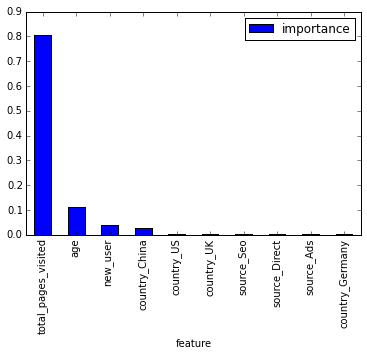

In [19]:
result.plot(kind='bar', x=result['feature'])

total_pages_visited dominates, which does not provide much information and guidence: since we cannot affect the how many times a user visit the page. Let's fit the model without this feature, and check feature importance

In [20]:
data_new = data.drop('total_pages_visited',1)
X_train, X_test, y_train, y_test = train_test_split(data_new.iloc[:,:-1], data_new.iloc[:,-1],test_size = 0.2)

In [21]:
rf = RandomForestClassifier().fit(X_train, y_train)
rf.score(X_test, y_test)

0.96763124604680584

In [22]:
importance = rf.feature_importances_
np.array(data_new.columns)[importance.argsort()[::-1]]

array(['new_user', 'age', 'country_China', 'country_US', 'country_UK',
       'country_Germany', 'source_Direct', 'source_Ads', 'source_Seo'], dtype=object)

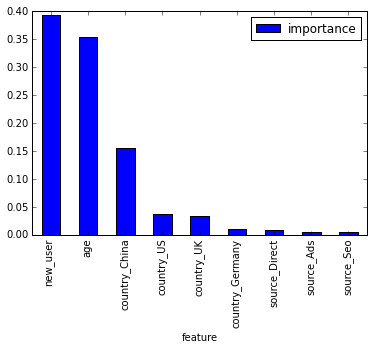

In [23]:
result = pd.DataFrame({'feature':np.array(data_new.columns)[importance.argsort()[::-1]], 
              'importance':np.sort(importance)[::-1]})
result.plot(kind='bar', x=result['feature'])

from this we can see that new_user and age play an important role. there seems some informatio in country_China, let's check them

In [24]:
data_orig = pd.read_csv('../conversion/conversion_data.csv')
data_orig = data_orig[data_orig['age'] <= 80]

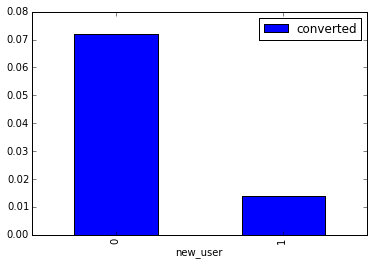

In [25]:
data_orig.groupby('new_user').agg({"converted":np.mean}).plot(kind='bar')

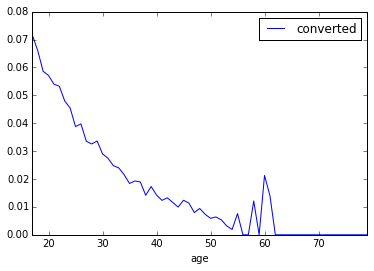

In [26]:
data_orig.groupby('age').agg({"converted":np.mean}).plot(kind='line')

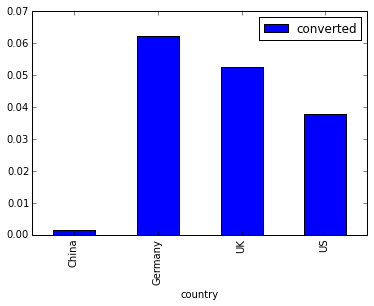

In [27]:
data_orig.groupby('country').agg({"converted":np.mean}).plot(kind='bar')

observation:
    
    
    1.returning users have much higher conversion rate than new user
    2.as age increases, the conversion rate drops significantly
    3.China has significantly lower converion rate than the other three.

recommendations:
  
    
    1.pay more attention to returning users, market more to make new users be returning customers by sending emails,    etc
    2.focus on young customers for marketing
    3.there should be some problem with Chinese version of the website, check the translation, UI design etc, regulation or cultural issue etc;